<a href="https://colab.research.google.com/github/jhill1/tidal_analysis_workshop/blob/main/Tidal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Tides are a fundemantal part of a number of coastal prcesses. As sea levels rise, tides will change, and hence our flood risk, coastal geomorphology and eolocigcal systems will also chnage as a consequence.

This Jupyter notebook will take you through the analysis of sea level data to extract tidal information.

# What to do

Run each block of code sequentially. In some places, template code is given for you to edit to carry out your own analysis.

There are questions posed along the way to help gai nunderstanding.


In [1]:
# let's install some essential python modules
!pip install wget
!pip install uptide

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=ef8caf4e00dc422dce3e7b60b771ea5c558b4abb8c2b4df1254595d33c8c5214
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
# import the modules we need
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wget
import os
import numpy as np
import uptide
import pytz


Now we have out environment set up. We can create a couple of "helper" functions to make life easier later!

In [3]:
def read_and_process_data(filename):
    tide_data = pd.read_csv(filename, header=None)
    tide_data['Date'] = pd.to_datetime(dict(year=tide_data[0], month=tide_data[1], day=tide_data[2], hour=tide_data[3]))
    # col 0 is year, col 1 is month, col2 is day, col3 hour
    tide_data = tide_data.drop([0,1,2,3], axis = 1)
    tide_data = tide_data.rename(columns={4: "Tide"})
    tide_data = tide_data.set_index('Date')
    tide_data = tide_data.mask(tide_data['Tide'] < -300)

    return tide_data

def extract_single_year_remove_mean(year, data):
    year_string_start = str(year)+"0101"
    year_string_end = str(year)+"1231"
    year_data = data.loc[year_string_start:year_string_end, ['Tide']]
    # remove mean to oscillate around zero
    mmm = np.mean(year_data['Tide'])
    year_data['Tide'] -= mmm

    return year_data

We are going to use data from the long term tidal record dataset held by the School of Ocean and Earth Science and Technology, University of Hawaii. Some of their tidal records go back over 100 years. We're going to download data for three locations in Australia: Freemantle, WA; Booby Island, QLD; and Fort Denison, NSW.

In [4]:
FortDenison_url = "https://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h333.csv"
BoobyIsland_url = "https://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h336.csv"
Freemantle_url = "https://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h175.csv"
urls = [FortDenison_url, BoobyIsland_url, Freemantle_url]

# fetch our data and store
for url in urls:
    file_name = os.path.basename(url) # get the full path to the file
    if os.path.exists(file_name):
        os.remove(file_name) # if exists, remove it directly
    file_name = wget.download(url, out=".")

We now have three csv files which should be stored in your temporary files here (click the little folder symbol to the left and you should see the three .csv files).

In [5]:
# load and store as a pandas dataframe
Fort_Denison = read_and_process_data("h333.csv")
Booby_Island = read_and_process_data("h336.csv")
Freemantle = read_and_process_data("h175.csv")


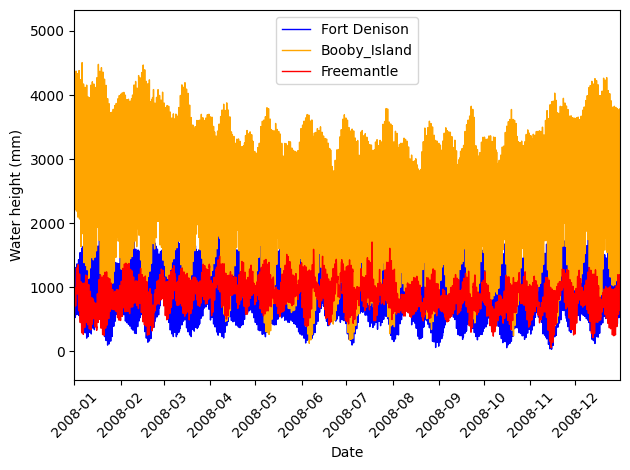

In [6]:
# Let's plot 1 years' worth of tidal data
fig_summary=plt.figure()
ax=fig_summary.add_subplot(111)
fd = ax.plot(Fort_Denison['Tide'], color="blue", lw=1, label="Fort Denison")
bi = ax.plot(Booby_Island['Tide'], color="orange", lw=1, label="Booby_Island")
f = ax.plot(Freemantle['Tide'], color="red", lw=1, label="Freemantle")
ax.set_xlabel("Date")
ax.set_ylabel("Water height (mm)")
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.set_xlim([datetime.date(2008, 1, 1), datetime.date(2008, 12, 31)])
fig_summary.tight_layout()

The plot, though busy, already shows some interesting features. Booby Island has the highest tidal range and shows a clear annual signal. Freemantle has the smallest tidal range and seems fairly constant. Let's now look at one month in detail:

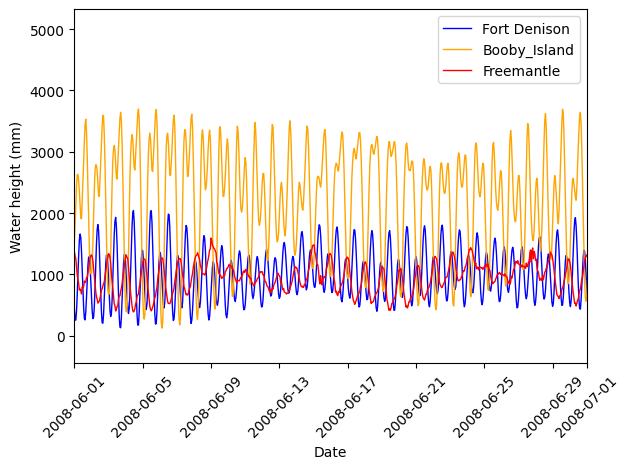

In [8]:
fig_june=plt.figure()
ax=fig_june.add_subplot(111)
fd = ax.plot(Fort_Denison['Tide'], color="blue", lw=1, label="Fort Denison")
bi = ax.plot(Booby_Island['Tide'], color="orange", lw=1, label="Booby_Island")
f = ax.plot(Freemantle['Tide'], color="red", lw=1, label="Freemantle")
ax.set_xlabel("Date")
ax.set_ylabel("Water height (mm)")
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.set_xlim([datetime.date(2008, 6, 1), datetime.date(2008, 7, 1)])
fig_june.tight_layout()

We can now see more of the tidal signals. You may notice Freemantle shows fewer wiggles than the other two locations; this is because it is a diurnal tide: one tide per day. Fort Denison has a clear two tides per day; semi-diurnal. Booby Island normally has two tides per days, but some days, those two tides effectively blend into one (see around the 17th June). This is a mixed diurnal-semi diurnal system.

All tidal signals are essentially a mix of multiple sine curves. We known what the frequency of the external forcing is for tides (the rotation of the earth, the movement of the moon around the earth, etc), which allows us to break up the signal into constituent parts: the tidal constituents. These are often given labels such as M2, S2, K1, O1, etc. Each one has a particular frequency as given in the table below.

Decription                        |	Darwin symbol | Period (h) | Speed (°/h)
----------------------------------|---------------|------------|------------
Principal lunar semidiurnal	      | M2            | 12.4206012 | 28.9841042
Principal solar semidiurnal	      | S2	          | 12         |	30	      
Lunar diurnal	                    | K1	          | 23.9344721 |	15.0410686
Lunar diurnal	                    | O1	          | 25.8193387 |	13.9430356
Lunisolar semidiurnal	            | K2	          |11.96723606 |	30.0821373
Larger lunar elliptic semidiurnal	| N2	          | 12.6583475 |	28.4397295

There are over 400 different contiuents, but 60-ish is considered enough for accurate tidal predictions, but fewer still can be used for useful tidal predictions. The tidal signal can then be reconstructed by summing sine curves of the correct frequency and amplitude (and phase) to recreate and then predict the tides. At each location the amplitude and phase will be different.

Let's add up some sine curves to make something like the tide signals above.


We can extract constituents from a tidal signal like those plotted above using least squares regression analysis. Let's do that now to pull out the common consituents from the out tidal data.

In [ ]:
# let's first pull out a single year's worth of data
# and remove the mean value so the tides oscillate across zero
FD_2008 = extract_single_year_remove_mean(2008, Fort_Denison)
BI_2008 = extract_single_year_remove_mean(2008, Booby_Island)
F_2008 = extract_single_year_remove_mean(2008, Freemantle)


In [ ]:
# We can use the module uptide to work out the tidal constiuents
# More on uptide: https://github.com/stephankramer/uptide
import uptide
# we create a Tides object with a list of the consituents we want.
tide = uptide.Tides(['M2'])
# We then set out start time. All data must then be in second since this time
tide.set_initial_time(datetime.datetime(2008,1,1,0,0,0))
# so let's swap our dates for seconds since midnight 1/1/2008.
# Note the 1e9 (the int64 seconds epoch in numpy is multiplied by this for some reason)
seconds_since = (FD_2008.index.astype('int64').to_numpy()/1e9) - datetime.datetime(2008,1,1,0,0,0).timestamp()
# We then send the elevation data (our tides) and time in seconds to uptide
# and do the harmonic analysis
amp,pha = uptide.harmonic_analysis(tide, FD_2008['Tide'].to_numpy()/1000, seconds_since)

# uptide returns the amplitudes as a list (in the order of the constiuents listed above) and the phases (in radians)
